In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from numpy.linalg import solve
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import math
import time
sns.set()
sns.set_style("darkgrid")

## Load the gender and the ratings data of the dating data set 

In [2]:
df_gender = pd.read_csv("../data/external/gender.dat",header=None,names=["UserID","Gender"])

In [3]:
df_ratings = pd.read_csv("../data/external/ratings.dat",header=None,error_bad_lines=False,names=["UserID","ProfileID","Rating"])

In [4]:
df_ratings.shape

(18242674, 3)

## subsetting code

Here we get the most active users in the data set and use them as a subset of our data

In [5]:
a = df_ratings.groupby("UserID") #get all the users

In [6]:
x = a.count()

In [7]:
subset_ids = x.sort_values(by="Rating",ascending=False).reset_index()["UserID"][:5000] #get idsof  the top 5000 users

In [8]:
df_ratings_new = df_ratings[df_ratings["UserID"].isin(subset_ids)]  #select the top 5000 people

In [9]:
df_ratings_new.shape

(6271116, 3)

In [10]:
mapping = {}
for i in range(len(subset_ids)):
    mapping[subset_ids[i]] = i

In [11]:
df_ratings_new["UserID"] = df_ratings_new["UserID"].map(mapping) #use the new mapping for the 5000 users


/home/roxor/bin/anaconda3/envs/personalization/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [12]:
df_ratings_new["UserID"].unique().shape

(5000,)

In [13]:
df_ratings_new = df_ratings_new[df_ratings_new["ProfileID"].isin(subset_ids)] #select only the profiles who have rated the top 5000 users

In [14]:
df_ratings_new["ProfileID"] = df_ratings_new["ProfileID"].map(mapping) #create a mapping 

In [15]:
df_ratings_new["ProfileID"].unique().shape

(3824,)

In [16]:
#convert from a sparse representation into a ratings matrix
ratings_matrix = pd.crosstab(index = df_ratings_new["UserID"],columns = df_ratings_new["ProfileID"],values =df_ratings_new["Rating"],aggfunc="mean")

In [17]:
ratings_matrix.shape

(5000, 3824)

In [18]:
#ratings_matrix = ratings_matrix.loc[:,ratings_matrix.index]

## subset data into different parts to look at algos scale with data

In [19]:
rating_subsets = [100,200,300,400,500,600,700,800,900,1000]

In [20]:
ratings = []
for i in range(len(rating_subsets)):
    ratings.append(ratings_matrix.iloc[:rating_subsets[i],:rating_subsets[i]])

In [21]:
mapping2 = ratings[-1].index #create a mapping of the data from the new profile ids to the old profile ids

In [22]:
for i in range(len(ratings)):
    ratings[i]= ratings[i].reset_index(drop=True) #reset row indexs
    ratings[i].columns = range(ratings[i].shape[1]) #reset column indexes
    ratings[i][np.isnan(ratings[i])] = 0 #reset nan values to 0
    ratings[i] = ratings[i].values #convert the data frame to a numpy array

In [23]:
assert np.sum(ratings[-1].sum(axis =1) ==0) ==0 # check that all users have atleast 1 rating given

## All the test are done on the ratings matrix with 100 x 100 pairs of users

In [24]:
def train_cv_test_split(ratings,train_percent=60):
    #take two of the elements from each row into the train test split
    test_fraction = (100-train_percent)/(2*100)
    cv_fraction = (100-train_percent)/(2*100)
    test = np.zeros(ratings.shape)
    cv = np.zeros(ratings.shape)
    train = ratings.copy()
    for user in range(ratings.shape[0]):
        ratings_user = ratings[user, :].nonzero()[0]
        length = len(ratings_user) 
        test_length = math.floor(length*test_fraction)
        test_cv_ratings = np.random.choice(ratings[user, :].nonzero()[0], 
                                        size=(2,test_length), 
                                        replace=False)

        train[user, test_cv_ratings] = 0.        
        test[user, test_cv_ratings[0]] = ratings[user, test_cv_ratings[0]]
        cv[user, test_cv_ratings[1]] = ratings[user, test_cv_ratings[1]]
        
    assert(np.all((train * cv * test) == 0)) 
    return train, cv , test

In [25]:
rating100 = ratings[0] #select the 100x100 ratings matrix

In [26]:
train,cv,test = train_cv_test_split(rating100,60)

## define the error calculation function

In [27]:
def get_mse(pred, actual):
    # select error on only the non zero terms
    pred = pred[actual.nonzero()].flatten()
    actual = actual[actual.nonzero()].flatten()
    return mean_squared_error(pred, actual)

In [28]:
def get_mae(pred, actual):
    # select error on only the non zero terms
    pred = pred[actual.nonzero()].flatten()
    actual = actual[actual.nonzero()].flatten()
    return mean_absolute_error(pred, actual)

# Matrix factorixation class

The class created below is used to perform matrix factorization using either stochasitic gradient descent or alternating least squares

## Params:

**ratings** : the ratings matrix which is used to learn the model

**latent_vetors** : the number of latent factors that should be created in the learnt matrix factorization

**item_reg** : the regularization term used for the item latent vectors

**user_reg** : The regulatization term used for user latent vectors
                
**learning**: the learning algorithm that should be used, this can be 'als'(Alternating least square) or 'sgd' stochastic gradient descent



In [29]:
class MatrixFactorization():
    def __init__(self, 
                 ratings,
                 latent_vectors=40,
                 item_reg=0.0, 
                 user_reg=0.0,
                 learning='sgd'):
        
        
        self.ratings = ratings
        self.n_users, self.n_items = ratings.shape
        self.latent_vectors = latent_vectors
        self.learning = learning
        if self.learning == 'sgd':
            self.sgd_row, self.sgd_col = self.ratings.nonzero()
            self.n_samples = len(self.sgd_row)
        self.item_reg = item_reg
        self.user_reg = user_reg


    def als_train(self,
                 latent_vector,
                 fixed_vec,
                 ratings,
                 _lambda,
                 type):
        #runs one step of the alternating least square algorithm holding either user 
        #or item latent vectors as constant
        if type == 'user':
            YTY = fixed_vec.T.dot(fixed_vec)
            lambdaI = np.eye(YTY.shape[0]) * _lambda

            for u in range(latent_vector.shape[0]):
                latent_vector[u, :] = solve((YTY + lambdaI), 
                                             ratings[u, :].dot(fixed_vec))
        elif type == 'item':
            XTX = fixed_vec.T.dot(fixed_vec)
            lambdaI = np.eye(XTX.shape[0]) * _lambda
            
            for i in range(latent_vector.shape[0]):
                latent_vector[i, :] = solve((XTX + lambdaI), 
                                             ratings[:, i].T.dot(fixed_vec))
        return latent_vector

    def train(self, n_iter=100, learning_rate=0.1):
        #runs the learning algorithm after the method is initialized
        self.user_vecs = np.random.rand(self.n_users, self.latent_vectors)
        self.item_vecs = np.random.rand(self.n_items, self.latent_vectors)
        
        if self.learning == 'als':
            self.__train(n_iter)
        elif self.learning == 'sgd':
            self.learning_rate = learning_rate
            self.__train(n_iter)
    
    
    def __train(self, n_iter):
        #runs the train process on the current set of user and item vectors
        #run this only after train has been called once
        i = 1
        while i <= n_iter:
            if i % 15 == 0 :
                print('\tcurrent iteration: {}'.format(i))
            if self.learning == 'als':
                self.user_vecs = self.als_train(self.user_vecs, 
                                               self.item_vecs, 
                                               self.ratings, 
                                               self.user_reg, 
                                               type='user')
                self.item_vecs = self.als_train(self.item_vecs, 
                                               self.user_vecs, 
                                               self.ratings, 
                                               self.item_reg, 
                                               type='item')
            elif self.learning == 'sgd':
                self.training_indices = np.arange(self.n_samples)
                np.random.shuffle(self.training_indices) #shuffle it to make it stochastic gradient descent
                self.sgd()
            i += 1

    def sgd(self):
        #updates the error terms based on the error and the learning rate
        for idx in self.training_indices:
            u = self.sgd_row[idx]
            i = self.sgd_col[idx]
            prediction = self.predict_user_item(u, i)
            e = (self.ratings[u,i] - prediction)
           
            self.user_vecs[u, :] += self.learning_rate * (e * self.item_vecs[i, :] - self.user_reg * self.user_vecs[u,:])
            self.item_vecs[i, :] += self.learning_rate * (e * self.user_vecs[u, :] - self.item_reg * self.item_vecs[i,:])
    
    def predict_user_item(self, u,i):
        #preduct for a particular user item pair
        return self.user_vecs[u, :].dot(self.item_vecs[i, :].T)
    
    def predict_all(self):
        #predict the items for all the users nad all the items
        predictions = np.zeros((self.user_vecs.shape[0], 
                                self.item_vecs.shape[0]))
        for u in range(self.user_vecs.shape[0]):
            for i in range(self.item_vecs.shape[0]):
                predictions[u, i] = self.predict_user_item(u, i)
                
        return predictions
    
    def get_top_k_reco_user(self, u, k):
        #return the top k recommendations for a user
        prediction_u = self.user_vecs[u, :].dot(self.item_vecs.T)
        prediction_u[u] = -np.Inf #set prediction of the user as lowest for himself
        prediction_u_sorted =(-prediction_u).argsort()
        return prediction_u_sorted[:k]
        
    
    def calc_learning_curve(self, iter_array, test=None, learning_rate=0.1):
        #runs the algorithm and calculated the curve at the different iter_array points
        iter_array.sort()
        self.train_mse =[]
        self.test_mse = []
        self.train_mae = []
        self.test_mae = []
        iter_diff = 0
        for (i, n_iter) in enumerate(iter_array):
            print('Iteration: {}'.format(n_iter))
            if i == 0:
                self.train(n_iter - iter_diff, learning_rate)
            else:
                self.__train(n_iter - iter_diff)

            predictions = self.predict_all()
            self.train_mse.append(get_mse(predictions, self.ratings))
            if not(test is None):
                self.test_mse.append(get_mse(predictions, test))
            self.train_mae.append(get_mae(predictions, self.ratings))
            if not(test is None):
                self.test_mae.append(get_mae(predictions, test))
            print('Train data  mse: ' + str(self.train_mse[-1]))
            if not(test is None):
                print('Test data mse: ' + str(self.test_mse[-1]))
            iter_diff = n_iter

In [30]:
als = MatrixFactorization(train, 40,learning='als')
iter_array = np.linspace(0,200,21)
als.calc_learning_curve(iter_array, cv)

Iteration: 0.0
Train data  mse: 26.4588325078678
Test data mse: 24.36342066948539
Iteration: 10.0
Train data  mse: 0.7545401192528963
Test data mse: 44.87715035394936
Iteration: 20.0
Train data  mse: 0.7545720003513213
Test data mse: 44.866762919387924
Iteration: 30.0
Train data  mse: 0.7565887667027639
Test data mse: 44.87708581878998
Iteration: 40.0
Train data  mse: 0.7570851590791996
Test data mse: 44.88027061588564
Iteration: 50.0
Train data  mse: 0.757200480727148
Test data mse: 44.88130653158613
Iteration: 60.0
Train data  mse: 0.75723748421503
Test data mse: 44.88172737269275
Iteration: 70.0
Train data  mse: 0.7572566938745511
Test data mse: 44.881939240616084
Iteration: 80.0
Train data  mse: 0.7572694093291438
Test data mse: 44.88206065618573
Iteration: 90.0
Train data  mse: 0.757278161817387
Test data mse: 44.88213441743734
Iteration: 100.0
Train data  mse: 0.757284076283932
Test data mse: 44.8821802103689
Iteration: 110.0
Train data  mse: 0.7572879785099207
Test data mse: 44.

In [31]:
als.get_top_k_reco_user(34,6)

array([ 6, 66, 18, 74, 65, 91])

In [32]:
def plot_mse_learning_curve(iter_array, model,test_label="Test"):
    plt.plot(iter_array, model.train_mse, \
             label='Training', linewidth=2,color="green")
    plt.plot(iter_array, model.test_mse, \
             label=test_label, linewidth=2,color="red")


    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.xlabel('iterations', fontsize=30)
    plt.ylabel('MSE', fontsize=30)
    plt.legend(loc='best', fontsize=20)
    plt.title("Plot with mean square error",fontsize=30)

In [33]:
def plot_mae_learning_curve(iter_array, model,test_label="Test"):
    plt.plot(iter_array, model.train_mae, \
             label='Training', linewidth=2,color="green")
    plt.plot(iter_array, model.test_mae, \
             label=test_label, linewidth=2,color="red")


    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.xlabel('iterations', fontsize=30)
    plt.ylabel('MAE', fontsize=30)
    plt.legend(loc='best', fontsize=20)
    plt.title("Plot with mean absolute error",fontsize=30)

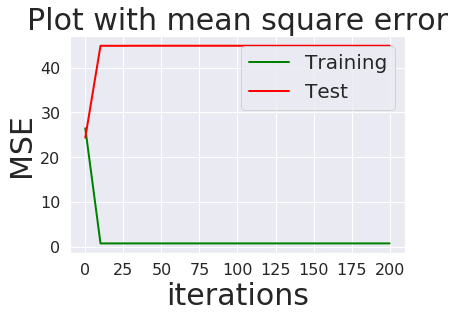

In [34]:
plot_mse_learning_curve(iter_array, als)

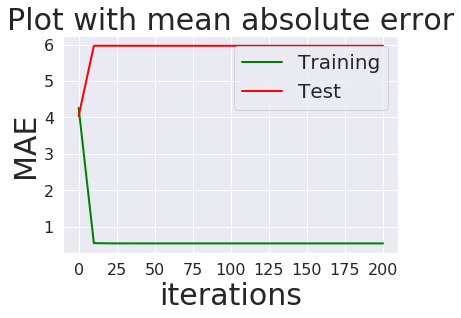

In [35]:
plot_mae_learning_curve(iter_array, als)

### trying regularization

In [36]:
als = MatrixFactorization(train, latent_vectors=4, 
                    user_reg=5., item_reg=5.,learning="als")

iter_array = np.linspace(0,200,21)
als.calc_learning_curve(iter_array, cv)

Iteration: 0.0
Train data  mse: 33.25446806974576
Test data mse: 37.542859959016866
Iteration: 10.0
Train data  mse: 20.365309344535543
Test data mse: 33.0980439449956
Iteration: 20.0
Train data  mse: 20.291996466728378
Test data mse: 32.94331241339224
Iteration: 30.0
Train data  mse: 20.285982966498256
Test data mse: 32.93224687472412
Iteration: 40.0
Train data  mse: 20.285400475055962
Test data mse: 32.9312095122037
Iteration: 50.0
Train data  mse: 20.28534224135557
Test data mse: 32.93110591132986
Iteration: 60.0
Train data  mse: 20.285336369845027
Test data mse: 32.931095420671674
Iteration: 70.0
Train data  mse: 20.285335776287766
Test data mse: 32.93109435513339
Iteration: 80.0
Train data  mse: 20.28533571622683
Test data mse: 32.93109424682593
Iteration: 90.0
Train data  mse: 20.285335710146555
Test data mse: 32.9310942358137
Iteration: 100.0
Train data  mse: 20.285335709530823
Test data mse: 32.93109423469375
Iteration: 110.0
Train data  mse: 20.285335709468455
Test data mse: 3

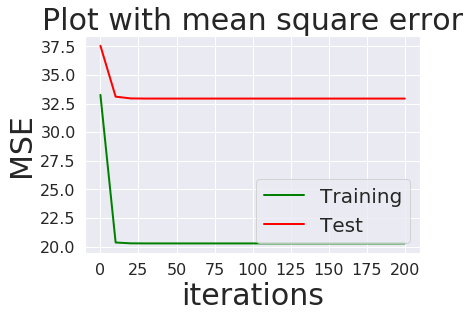

In [37]:
plot_mse_learning_curve(iter_array, als)

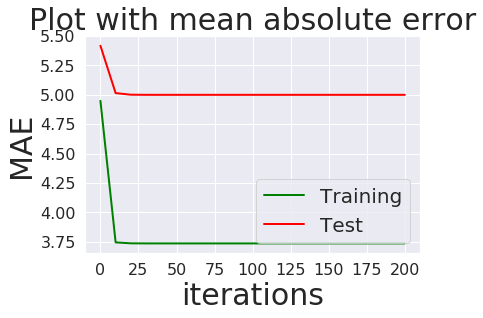

In [38]:
plot_mae_learning_curve(iter_array, als)

Now we tune the hyperparameters using the test set and report it on the test data

In [95]:

latent_factors = [2 ,4 ,5, 10, 20, 40, 80]
regularizations = [0.1, 1., 10., 100.]
regularizations.sort()
iter_array = np.linspace(10,200,20)
hyperparams_rows = []
best_params_als = {}
best_params_als['latent_vectors'] = latent_factors[0]
best_params_als['reg'] = regularizations[0]
best_params_als['n_iter'] = 0
best_params_als['train_mse'] = np.inf
best_params_als['cv_mse'] = np.inf

for fact in latent_factors:
    print('Factors: {}'.format(fact))
    for reg in regularizations:
        print('Regularization: {}'.format(reg))
        MF_ALS = MatrixFactorization(train, latent_vectors=fact, 
                            user_reg=reg, item_reg=reg,learning='als')
        MF_ALS.calc_learning_curve(iter_array, cv)
        min_idx = np.argmin(MF_ALS.test_mse[1:])
        hyperparams_rows.append({"latent_factor":fact,
                                   "User_regularization":reg,
                                   "item_regularization":reg,
                                   "test_mse":MF_ALS.test_mse[min_idx],
                                   "test_mae":MF_ALS.test_mae[min_idx]
                                  })
        if MF_ALS.test_mse[min_idx] < best_params_als['cv_mse'] and iter_array[min_idx] > 0:
            best_params_als['latent_vectors'] = fact
            best_params_als['reg'] = reg
            best_params_als['n_iter'] = iter_array[min_idx]
            best_params_als['train_mse'] = MF_ALS.train_mse[min_idx]
            best_params_als['cv_mse'] = MF_ALS.test_mse[min_idx]
            print('New optimal hyperparameters')
            print(pd.Series(best_params_als))

Factors: 2
Regularization: 0.1
Iteration: 10.0
Train data  mse: 24.85565543197616
Test data mse: 26.681187861317003
Iteration: 20.0
Train data  mse: 24.83735361490877
Test data mse: 26.49517987639555
Iteration: 30.0
Train data  mse: 24.839070533877905
Test data mse: 26.48669324341622
Iteration: 40.0
Train data  mse: 24.839083155529753
Test data mse: 26.485782900585534
Iteration: 50.0
Train data  mse: 24.838940435854607
Test data mse: 26.485497224285066
Iteration: 60.0
Train data  mse: 24.838793811377535
Test data mse: 26.48527768062992
Iteration: 70.0
Train data  mse: 24.83865552159232
Test data mse: 26.48507556438258
Iteration: 80.0
Train data  mse: 24.838525836436716
Test data mse: 26.484885797132034
Iteration: 90.0
Train data  mse: 24.83840408357002
Test data mse: 26.484707128995847
Iteration: 100.0
Train data  mse: 24.838289585236954
Test data mse: 26.48453871512865
Iteration: 110.0
Train data  mse: 24.83818172973988
Test data mse: 26.48437981344348
Iteration: 120.0
Train data  mse

Train data  mse: 19.47192400945646
Test data mse: 27.203814561277323
Iteration: 180.0
Train data  mse: 19.471718237753933
Test data mse: 27.203529863260083
Iteration: 190.0
Train data  mse: 19.471528946122067
Test data mse: 27.203265147022325
Iteration: 200.0
Train data  mse: 19.47135429836731
Test data mse: 27.20301853483436
Regularization: 1.0
Iteration: 10.0
Train data  mse: 19.719556122778993
Test data mse: 27.424179063323496
Iteration: 20.0
Train data  mse: 19.687266986772762
Test data mse: 27.345052757919234
Iteration: 30.0
Train data  mse: 19.67309037642477
Test data mse: 27.322293152873492
Iteration: 40.0
Train data  mse: 19.665398255424247
Test data mse: 27.310820911059317
Iteration: 50.0
Train data  mse: 19.66093034205672
Test data mse: 27.304196960925523
Iteration: 60.0
Train data  mse: 19.658211074288673
Test data mse: 27.300143652099344
Iteration: 70.0
Train data  mse: 19.65651242574492
Test data mse: 27.297600975443427
Iteration: 80.0
Train data  mse: 19.65543580862184
Te

Train data  mse: 17.936475232228627
Test data mse: 29.117423002853837
Iteration: 130.0
Train data  mse: 17.93638971393049
Test data mse: 29.11725954741851
Iteration: 140.0
Train data  mse: 17.936334244353336
Test data mse: 29.117156431636218
Iteration: 150.0
Train data  mse: 17.93629826366197
Test data mse: 29.117090375061686
Iteration: 160.0
Train data  mse: 17.936274931741437
Test data mse: 29.11704776783358
Iteration: 170.0
Train data  mse: 17.93625980794198
Test data mse: 29.11702020644541
Iteration: 180.0
Train data  mse: 17.93625000831433
Test data mse: 29.1170023583135
Iteration: 190.0
Train data  mse: 17.93624366055516
Test data mse: 29.11699079661797
Iteration: 200.0
Train data  mse: 17.93623954981656
Test data mse: 29.116983307176845
Regularization: 10.0
Iteration: 10.0
Train data  mse: 20.174419845966003
Test data mse: 29.087980399740665
Iteration: 20.0
Train data  mse: 20.172981923620043
Test data mse: 29.59225817144078
Iteration: 30.0
Train data  mse: 20.178614925804762
Te

Train data  mse: 14.565426281515672
Test data mse: 32.00194742532889
Iteration: 100.0
Train data  mse: 14.565155356268136
Test data mse: 32.0023928945151
Iteration: 110.0
Train data  mse: 14.564986852990977
Test data mse: 32.00259722874539
Iteration: 120.0
Train data  mse: 14.564881743252752
Test data mse: 32.002689477809305
Iteration: 130.0
Train data  mse: 14.564816051331603
Test data mse: 32.00273013376113
Iteration: 140.0
Train data  mse: 14.564774940428705
Test data mse: 32.002747390455355
Iteration: 150.0
Train data  mse: 14.564749188356046
Test data mse: 32.002754265225
Iteration: 160.0
Train data  mse: 14.564733046097524
Test data mse: 32.00275668610765
Iteration: 170.0
Train data  mse: 14.56472292253338
Test data mse: 32.002757299145536
Iteration: 180.0
Train data  mse: 14.564716571240261
Test data mse: 32.0027572502567
Iteration: 190.0
Train data  mse: 14.564712585502546
Test data mse: 32.002757012131994
Iteration: 200.0
Train data  mse: 14.564710083760028
Test data mse: 32.0

Train data  mse: 44.74839398941175
Test data mse: 41.97983869660857
Iteration: 70.0
Train data  mse: 44.748394003503215
Test data mse: 41.97983870899243
Iteration: 80.0
Train data  mse: 44.7483940042418
Test data mse: 41.979838709641506
Iteration: 90.0
Train data  mse: 44.74839400428052
Test data mse: 41.97983870967554
Iteration: 100.0
Train data  mse: 44.748394004282545
Test data mse: 41.979838709677324
Iteration: 110.0
Train data  mse: 44.74839400428265
Test data mse: 41.979838709677416
Iteration: 120.0
Train data  mse: 44.74839400428265
Test data mse: 41.979838709677416
Iteration: 130.0
Train data  mse: 44.74839400428265
Test data mse: 41.979838709677416
Iteration: 140.0
Train data  mse: 44.74839400428265
Test data mse: 41.979838709677416
Iteration: 150.0
Train data  mse: 44.74839400428265
Test data mse: 41.979838709677416
Iteration: 160.0
Train data  mse: 44.74839400428265
Test data mse: 41.979838709677416
Iteration: 170.0
Train data  mse: 44.74839400428265
Test data mse: 41.979838

Train data  mse: 0.0006801759860533993
Test data mse: 41.92323467388817
Iteration: 20.0
Train data  mse: 0.0004762203370403019
Test data mse: 41.927936043785905
Iteration: 30.0
Train data  mse: 0.00043328268127060206
Test data mse: 41.92814660310602
Iteration: 40.0
Train data  mse: 0.00042719009258106806
Test data mse: 41.927098743461876
Iteration: 50.0
Train data  mse: 0.0004337274569257821
Test data mse: 41.92560609879889
Iteration: 60.0
Train data  mse: 0.00044514715652028524
Test data mse: 41.923980265636345
Iteration: 70.0
Train data  mse: 0.0004583413444298948
Test data mse: 41.922365664800694
Iteration: 80.0
Train data  mse: 0.00047190406265798935
Test data mse: 41.920834152263126
Iteration: 90.0
Train data  mse: 0.00048516073184888395
Test data mse: 41.91942096253748
Iteration: 100.0
Train data  mse: 0.0004977852382042468
Test data mse: 41.91814123935731
Iteration: 110.0
Train data  mse: 0.0005096293540626228
Test data mse: 41.91699863530938
Iteration: 120.0
Train data  mse: 0.

In [96]:
hyperparams_als_df = pd.DataFrame(columns=["latent_factor","User_regularization","item_regularization","test_mse"
                                           ,"test_mae"])

In [97]:
hyperparams_als_df = hyperparams_als_df.append(hyperparams_rows)

/home/roxor/bin/anaconda3/envs/personalization/lib/python3.6/site-packages/pandas/core/frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


In [106]:
hyperparams_als_df

,User_regularization,item_regularization,latent_factor,test_mae,test_mse
0,0.1,0.1,2,4.334464,26.483381
1,1.0,1.0,2,4.465039,27.437142
2,10.0,10.0,2,4.487100,27.836269
3,100.0,100.0,2,5.743096,41.940746
4,0.1,0.1,4,4.378304,27.005513
5,1.0,1.0,4,4.412795,27.293121
6,10.0,10.0,4,4.521172,28.164408
7,100.0,100.0,4,5.742908,41.938193
8,0.1,0.1,5,4.533237,29.067664
9,1.0,1.0,5,4.429322,27.608967


## now that we have the optimal paramaeters we can plot it on the test data

In [86]:
best_params_als

{'latent_vectors': 2,
 'reg': 0.1,
 'n_iter': 190.0,
 'train_mse': 24.83904566120077,
 'cv_mse': 26.484418628624923}

In [57]:
best_als_model = MatrixFactorization(train, latent_vectors=best_params_als['latent_vectors'], 
                            user_reg=best_params_als['reg'], item_reg=best_params_als['reg'],learning='als')
best_als_model.calc_learning_curve(iter_array,test)

Iteration: 0.0
Train data  mse: 33.529566392597346
Test data mse: 33.39760879132036
Iteration: 10.0
Train data  mse: 19.66036602912578
Test data mse: 27.153137611168393
Iteration: 20.0
Train data  mse: 19.653520139551752
Test data mse: 27.26152455625102
Iteration: 30.0
Train data  mse: 19.650740756948508
Test data mse: 27.429278297303345
Iteration: 40.0
Train data  mse: 19.642786886408174
Test data mse: 27.6067995010464
Iteration: 50.0
Train data  mse: 19.63829078316253
Test data mse: 27.78642031748381
Iteration: 60.0
Train data  mse: 19.638449277542232
Test data mse: 27.956736254531624
Iteration: 70.0
Train data  mse: 19.64268109724234
Test data mse: 28.1087783472689
Iteration: 80.0
Train data  mse: 19.649855879397418
Test data mse: 28.237941885286062
Iteration: 90.0
Train data  mse: 19.65874698843821
Test data mse: 28.34358717782095
Iteration: 100.0
Train data  mse: 19.668297847411264
Test data mse: 28.427687863473196
Iteration: 110.0
Train data  mse: 19.677737092179846
Test data mse

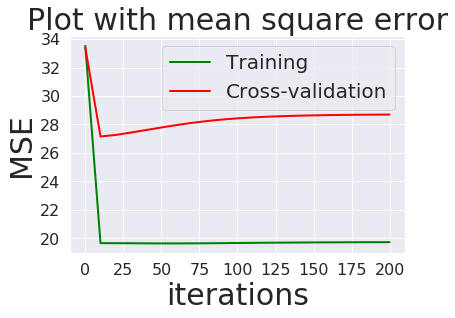

In [58]:
plot_mse_learning_curve(iter_array, best_als_model,"Cross-validation")

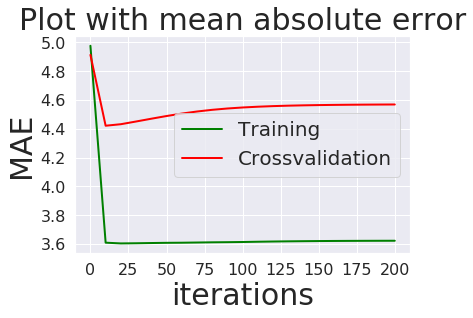

In [59]:
plot_mae_learning_curve(iter_array, best_als_model,"Crossvalidation")

## trying out the stochastic gradient algorithm now

In [36]:
sgd = MatrixFactorization(train, 80, learning='sgd')
iter_array = np.linspace(0,200,21)
sgd.calc_learning_curve(iter_array, cv, learning_rate=0.001)

Iteration: 0.0
Train data  mse: 214.49686465141698
Test data mse: 202.82754751781215
Iteration: 10.0
Train data  mse: 5.8489670088222985
Test data mse: 12.032347178351474
Iteration: 20.0
Train data  mse: 3.0982377981444404
Test data mse: 9.54383025524791
Iteration: 30.0
Train data  mse: 2.0978175284615697
Test data mse: 8.903141583623519
Iteration: 40.0
Train data  mse: 1.4828626956802156
Test data mse: 8.601244579050595
Iteration: 50.0
Train data  mse: 1.0555975510772508
Test data mse: 8.446383400298698
Iteration: 60.0
Train data  mse: 0.7494240906169439
Test data mse: 8.356497060877965
Iteration: 70.0
Train data  mse: 0.5297228081443535
Test data mse: 8.310371752431795
Iteration: 80.0
Train data  mse: 0.37328508915225117
Test data mse: 8.286453377105824
Iteration: 90.0
Train data  mse: 0.26291938435783724
Test data mse: 8.279016853433195
Iteration: 100.0
Train data  mse: 0.18559175477539352
Test data mse: 8.278875236098829
Iteration: 110.0
Train data  mse: 0.13158570091885965
Test da

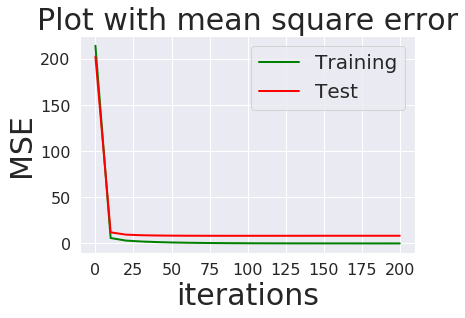

In [37]:
plot_mse_learning_curve(iter_array, sgd)

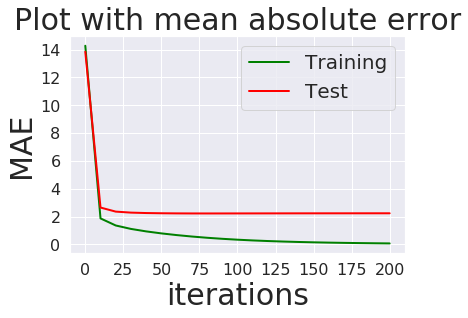

In [38]:
plot_mae_learning_curve(iter_array, sgd)

## now we tune the hyperparameters

In [46]:
#tuning for learning rate
iter_array = np.linspace(0,200,21)
learning_rates = [1e-5, 1e-4, 1e-3, 1e-2]

best_params = {}
best_params['learning_rate'] = None
best_params['n_iter'] = 0
best_params['train_mse'] = np.inf
best_params['cv_mse'] = np.inf


for rate in learning_rates:
    print('Rate: {}'.format(rate))
    MF_SGD = MatrixFactorization(train, latent_vectors=40, learning='sgd')
    MF_SGD.calc_learning_curve(iter_array, cv, learning_rate=rate)
    min_idx = np.argmin(MF_SGD.test_mse)
    if MF_SGD.test_mse[min_idx] < best_params['cv_mse']:
        best_params['n_iter'] = iter_array[min_idx]
        best_params['learning_rate'] = rate
        best_params['train_mse'] = MF_SGD.train_mse[min_idx]
        best_params['cv_mse'] = MF_SGD.test_mse[min_idx]
        print('New optimal hyperparameters')
        print(pd.Series(best_params))

Rate: 1e-05
Iteration: 0.0
Train data  mse: 27.840911512052553
Test data mse: 27.463785698913405
Iteration: 10.0
Train data  mse: 26.587637292625605
Test data mse: 26.374944209540672
Iteration: 20.0
Train data  mse: 25.42260979433326
Test data mse: 25.360532310171042
Iteration: 30.0
Train data  mse: 24.338007517413498
Test data mse: 24.414155451493748
Iteration: 40.0
Train data  mse: 23.326853290251375
Test data mse: 23.53011371792562
Iteration: 50.0
Train data  mse: 22.382903174309572
Test data mse: 22.703283393324725
Iteration: 60.0
Train data  mse: 21.500553566735
Test data mse: 21.92904059576505
Iteration: 70.0
Train data  mse: 20.674735276268084
Test data mse: 21.20320385747817
Iteration: 80.0
Train data  mse: 19.900886729732548
Test data mse: 20.521992011199576
Iteration: 90.0
Train data  mse: 19.174907123512856
Test data mse: 19.88199365018761
Iteration: 100.0
Train data  mse: 18.493064712141294
Test data mse: 19.280107275076386
Iteration: 110.0
Train data  mse: 17.8519798798633

In [47]:
print("best learning rate is {}".format(best_params['learning_rate']))

best learning rate is 0.001


## tuning for latent_vectors and regularization

In [108]:
iter_array = np.linspace(10,200,20)
latent_factors = [5, 10, 20, 40, 80]
regularizations = [0.001, 0.01, 0.1, 1.]
regularizations.sort()
hyperparams_rows = []
best_params_sgd = {}
best_params_sgd['latent_vectors'] = latent_factors[0]
best_params_sgd['reg'] = regularizations[0]
best_params_sgd['n_iter'] = 0
best_params_sgd['train_mse'] = np.inf
best_params_sgd['cv_mse'] = np.inf

for fact in latent_factors:
    print('Factors: {}'.format(fact))
    for reg in regularizations:
        print('Regularization: {}'.format(reg))
        MF_SGD = MatrixFactorization(train, latent_vectors=fact, learning='sgd',
                            user_reg=reg, item_reg=reg)
        MF_SGD.calc_learning_curve(iter_array, cv, learning_rate=0.001)
        min_idx = np.argmin(MF_SGD.test_mse)
        hyperparams_rows.append({"latent_factor":fact,
                                   "User_regularization":reg,
                                   "item_regularization":reg,
                                   "alpha":0.001,
                                   "test_mse":MF_SGD.test_mse[min_idx],
                                   "test_mae":MF_SGD.test_mae[min_idx],
                                  })
        if MF_SGD.test_mse[min_idx] < best_params_sgd['cv_mse']:
            best_params_sgd['latent_vectors'] = fact
            best_params_sgd['reg'] = reg
            best_params_sgd['n_iter'] = iter_array[min_idx]
            best_params_sgd['train_mse'] = MF_SGD.train_mse[min_idx]
            best_params_sgd['cv_mse'] = MF_SGD.test_mse[min_idx]
            print('New optimal hyperparameters')
            print(pd.Series(best_params_sgd))

Factors: 5
Regularization: 0.001
Iteration: 10.0
Train data  mse: 12.50549564279404
Test data mse: 12.252358378883052
Iteration: 20.0
Train data  mse: 6.106784083582504
Test data mse: 7.173117701830141
Iteration: 30.0
Train data  mse: 4.606737761298149
Test data mse: 6.133375154896781
Iteration: 40.0
Train data  mse: 4.056730081739986
Test data mse: 5.813723346080895
Iteration: 50.0
Train data  mse: 3.763931802736453
Test data mse: 5.689767170639252
Iteration: 60.0
Train data  mse: 3.5629326468239317
Test data mse: 5.639521629240927
Iteration: 70.0
Train data  mse: 3.399829888944948
Test data mse: 5.629446233120666
Iteration: 80.0
Train data  mse: 3.252059637037062
Test data mse: 5.6374730601511684
Iteration: 90.0
Train data  mse: 3.1092101288540013
Test data mse: 5.661028079610364
Iteration: 100.0
Train data  mse: 2.9665156074077768
Test data mse: 5.696639280367465
Iteration: 110.0
Train data  mse: 2.8224745447660866
Test data mse: 5.7449977851613205
Iteration: 120.0
Train data  mse: 

Train data  mse: 1.882135045876751
Test data mse: 5.523827513595012
Iteration: 140.0
Train data  mse: 1.7203771758336985
Test data mse: 5.568420157416314
Iteration: 150.0
Train data  mse: 1.568401065964872
Test data mse: 5.616031961836368
Iteration: 160.0
Train data  mse: 1.4276214771736377
Test data mse: 5.668597786134784
Iteration: 170.0
Train data  mse: 1.2985658808737923
Test data mse: 5.7285938824872575
Iteration: 180.0
Train data  mse: 1.1811657525518175
Test data mse: 5.789302647892117
Iteration: 190.0
Train data  mse: 1.0749468779611346
Test data mse: 5.850069669557346
Iteration: 200.0
Train data  mse: 0.9791863607020318
Test data mse: 5.913892033795916
Regularization: 0.01
Iteration: 10.0
Train data  mse: 7.318730604285246
Test data mse: 7.948639788562921
Iteration: 20.0
Train data  mse: 4.63973959038346
Test data mse: 6.031289258320664
Iteration: 30.0
Train data  mse: 3.8889367934847074
Test data mse: 5.621698287752796
Iteration: 40.0
Train data  mse: 3.5229611095066717
Test 

Train data  mse: 2.830150844241397
Test data mse: 5.212105734977342
Iteration: 60.0
Train data  mse: 2.5882316472593523
Test data mse: 5.223953508424068
Iteration: 70.0
Train data  mse: 2.3536496590128433
Test data mse: 5.240217724365655
Iteration: 80.0
Train data  mse: 2.12359009158564
Test data mse: 5.258569507617242
Iteration: 90.0
Train data  mse: 1.8995923678562971
Test data mse: 5.283952521616551
Iteration: 100.0
Train data  mse: 1.6850871206390592
Test data mse: 5.313269500544946
Iteration: 110.0
Train data  mse: 1.4836973413755132
Test data mse: 5.348890026798257
Iteration: 120.0
Train data  mse: 1.2983799922227395
Test data mse: 5.390555798699981
Iteration: 130.0
Train data  mse: 1.1308652952568172
Test data mse: 5.43578670988395
Iteration: 140.0
Train data  mse: 0.9817536688554052
Test data mse: 5.486701808208713
Iteration: 150.0
Train data  mse: 0.8506775667031253
Test data mse: 5.539754672173271
Iteration: 160.0
Train data  mse: 0.7365699703813681
Test data mse: 5.594420151

Train data  mse: 0.1927440273597403
Test data mse: 5.770673944994869
Iteration: 180.0
Train data  mse: 0.15994559816615925
Test data mse: 5.79321893371094
Iteration: 190.0
Train data  mse: 0.13334064000165413
Test data mse: 5.812723485955285
Iteration: 200.0
Train data  mse: 0.11168255216965807
Test data mse: 5.830366865800971
Regularization: 0.1
Iteration: 10.0
Train data  mse: 4.920055052495681
Test data mse: 6.904381183305134
Iteration: 20.0
Train data  mse: 3.4851078997996763
Test data mse: 5.6997264770235745
Iteration: 30.0
Train data  mse: 2.86223752203114
Test data mse: 5.416728513473693
Iteration: 40.0
Train data  mse: 2.442019503146977
Test data mse: 5.31413965685733
Iteration: 50.0
Train data  mse: 2.1093108880235314
Test data mse: 5.270930295104671
Iteration: 60.0
Train data  mse: 1.8280814206515121
Test data mse: 5.2529245909135
Iteration: 70.0
Train data  mse: 1.5830119926172763
Test data mse: 5.247425835186791
Iteration: 80.0
Train data  mse: 1.3685122608094826
Test data 

Train data  mse: 0.2711907973547551
Test data mse: 6.600576087451308
Iteration: 130.0
Train data  mse: 0.229702112738785
Test data mse: 6.548981940723104
Iteration: 140.0
Train data  mse: 0.1979220911700252
Test data mse: 6.501415749383528
Iteration: 150.0
Train data  mse: 0.17319682977205567
Test data mse: 6.456755463263052
Iteration: 160.0
Train data  mse: 0.15399713728213457
Test data mse: 6.414373503759152
Iteration: 170.0
Train data  mse: 0.13885776016431295
Test data mse: 6.373508452600626
Iteration: 180.0
Train data  mse: 0.127013129187159
Test data mse: 6.334156983854189
Iteration: 190.0
Train data  mse: 0.11744652601841085
Test data mse: 6.296630821598329
Iteration: 200.0
Train data  mse: 0.10977108320066245
Test data mse: 6.260628962616976
Regularization: 1.0
Iteration: 10.0
Train data  mse: 5.628137315216476
Test data mse: 10.768365138034282
Iteration: 20.0
Train data  mse: 3.9440872373536227
Test data mse: 8.138398219024156
Iteration: 30.0
Train data  mse: 3.586936254630226

In [110]:
hyperparams_sgd_df = pd.DataFrame(columns=["latent_factor","User_regularization","item_regularization","alpha","test_mse"
                                           ,"test_mae"])

In [111]:
hyperparams_sgd_df = hyperparams_sgd_df.append(hyperparams_rows)

In [112]:
hyperparams_sgd_df

,latent_factor,User_regularization,item_regularization,alpha,test_mse,test_mae
0,5,0.001,0.001,0.001,5.629446,1.774052
1,5,0.010,0.010,0.001,5.393264,1.704704
2,5,0.100,0.100,0.001,5.550021,1.756418
3,5,1.000,1.000,0.001,6.152843,1.854561
4,10,0.001,0.001,0.001,5.409097,1.741107
5,10,0.010,0.010,0.001,5.457148,1.791856
6,10,0.100,0.100,0.001,5.352246,1.756356
7,10,1.000,1.000,0.001,6.125220,1.860785
8,20,0.001,0.001,0.001,5.250780,1.825336
9,20,0.010,0.010,0.001,5.207429,1.770462


In [113]:
best_params_sgd

{'latent_vectors': 20,
 'reg': 0.1,
 'n_iter': 30.0,
 'train_mse': 3.369468795893607,
 'cv_mse': 5.002533484586904}

In [50]:
best_sgd_model =MatrixFactorization(train, latent_vectors=best_params_sgd['latent_vectors'], learning='sgd',
                            user_reg=best_params_sgd['reg'], item_reg=best_params_sgd['reg'])
best_sgd_model.calc_learning_curve(iter_array, cv, learning_rate=0.001)

Iteration: 0.0
Train data  mse: 10.983815536988295
Test data mse: 10.94117685624803
Iteration: 10.0
Train data  mse: 4.92890625696701
Test data mse: 6.410297723740831
Iteration: 20.0
Train data  mse: 3.7546908570751794
Test data mse: 5.71867840512623
Iteration: 30.0
Train data  mse: 3.259978217672327
Test data mse: 5.583477453345781
Iteration: 40.0
Train data  mse: 2.9258597085077036
Test data mse: 5.578084348939574
Iteration: 50.0
Train data  mse: 2.643621911395395
Test data mse: 5.615517826625113
Iteration: 60.0
Train data  mse: 2.381871726053305
Test data mse: 5.675320804665733
Iteration: 70.0
Train data  mse: 2.1316591254389645
Test data mse: 5.74008383209375
Iteration: 80.0
Train data  mse: 1.8922181580351012
Test data mse: 5.81473817319017
Iteration: 90.0
Train data  mse: 1.665952828978436
Test data mse: 5.896457861979595
Iteration: 100.0
Train data  mse: 1.4560596736279356
Test data mse: 5.977206754952511
Iteration: 110.0
Train data  mse: 1.2652474807947574
Test data mse: 6.0633

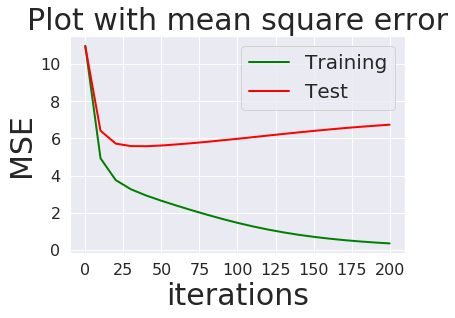

In [51]:
plot_mse_learning_curve(iter_array,best_sgd_model)

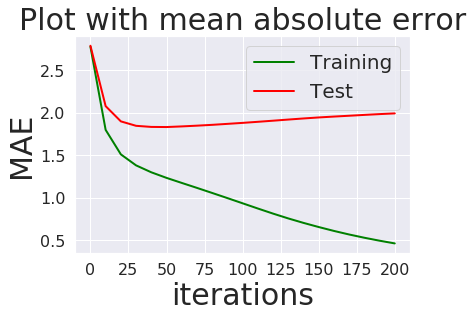

In [52]:
plot_mae_learning_curve(iter_array,best_sgd_model)

In [54]:
best_sgd_model.get_top_k_reco_user(0,6)

array([76,  6, 77, 41, 94, 18])

In [60]:
best_als_model.get_top_k_reco_user(0,6)

array([94, 84, 93,  2, 27, 38])

## now we see the scaling of the data in terms of the time it takes

In [ ]:
start_time_als = []

In [ ]:
end_time_als = []

In [ ]:
time_als = []

In [ ]:
start_time_sgd = []

In [ ]:
end_time_sgd = []

In [ ]:
time_sgd = []

In [82]:
for rating in ratings:
    #time als
    start = time.time()
    best_als_model = MatrixFactorization(rating, latent_vectors=best_params_als['latent_vectors'], 
                            user_reg=best_params_als['reg'], item_reg=best_params_als['reg'],learning='als')
    best_als_model.calc_learning_curve(iter_array)
    end = time.time() 
    start_time_als.append(start)
    end_time_als.append(end)
    time_als.append(end-start)
    
    #time sgd
    
    start = time.time()
    best_sgd_model =MatrixFactorization(rating, latent_vectors=best_params_sgd['latent_vectors'], learning='sgd',
                            user_reg=best_params_sgd['reg'], item_reg=best_params_sgd['reg'])
    best_sgd_model.calc_learning_curve(iter_array, learning_rate=0.001)
    end = time.time() 
    start_time_sgd.append(start)
    end_time_sgd.append(end)
    time_sgd.append(end-start)

Iteration: 0.0
Train data  mse: 10.015244949489732
Iteration: 10.0
Train data  mse: 3.786725144708658
Iteration: 20.0
Train data  mse: 3.7580900736587775
Iteration: 30.0
Train data  mse: 3.7468645536192158
Iteration: 40.0
Train data  mse: 3.7509175208727017
Iteration: 50.0
Train data  mse: 3.7531466025802165
Iteration: 60.0
Train data  mse: 3.7540592274505475
Iteration: 70.0
Train data  mse: 3.7544417988119028
Iteration: 80.0
Train data  mse: 3.754607934477755
Iteration: 90.0
Train data  mse: 3.754681100712959
Iteration: 100.0
Train data  mse: 3.754713540454735
Iteration: 110.0
Train data  mse: 3.7547287871833253
Iteration: 120.0
Train data  mse: 3.75473780189351
Iteration: 130.0
Train data  mse: 3.754745668497136
Iteration: 140.0
Train data  mse: 3.7547546060053425
Iteration: 150.0
Train data  mse: 3.754765413525335
Iteration: 160.0
Train data  mse: 3.7547781960142483
Iteration: 170.0
Train data  mse: 3.7547927388203357
Iteration: 180.0
Train data  mse: 3.754808702354913
Iteration: 19

Train data  mse: 1.4010962182028728
Iteration: 120.0
Train data  mse: 1.2691492632248318
Iteration: 130.0
Train data  mse: 1.1601214831892108
Iteration: 140.0
Train data  mse: 1.0688804550607052
Iteration: 150.0
Train data  mse: 0.9915579176367578
Iteration: 160.0
Train data  mse: 0.9251811230590316
Iteration: 170.0
Train data  mse: 0.867627712241334
Iteration: 180.0
Train data  mse: 0.8172269792633238
Iteration: 190.0
Train data  mse: 0.7727153254469513
Iteration: 200.0
Train data  mse: 0.7331226365636536
Iteration: 0.0
Train data  mse: 11.352971707868708
Iteration: 10.0
Train data  mse: 12.813173499865126
Iteration: 20.0
Train data  mse: 12.808147400922977
Iteration: 30.0
Train data  mse: 12.806013668945575
Iteration: 40.0
Train data  mse: 12.800271035736642
Iteration: 50.0
Train data  mse: 12.794778061839349
Iteration: 60.0
Train data  mse: 12.791386677601583
Iteration: 70.0
Train data  mse: 12.789332710373786
Iteration: 80.0
Train data  mse: 12.78794835653481
Iteration: 90.0
Train 

Train data  mse: 11.137948325861892
Iteration: 10.0
Train data  mse: 4.398916826055307
Iteration: 20.0
Train data  mse: 4.049291046394085
Iteration: 30.0
Train data  mse: 3.7140417480349943
Iteration: 40.0
Train data  mse: 3.3259346785515413
Iteration: 50.0
Train data  mse: 2.918222208851914
Iteration: 60.0
Train data  mse: 2.5505089945990718
Iteration: 70.0
Train data  mse: 2.25189551652405
Iteration: 80.0
Train data  mse: 2.017407883823134
Iteration: 90.0
Train data  mse: 1.8323824152626524
Iteration: 100.0
Train data  mse: 1.684214930855315
Iteration: 110.0
Train data  mse: 1.5634885694301837
Iteration: 120.0
Train data  mse: 1.4635007388300645
Iteration: 130.0
Train data  mse: 1.379490957195325
Iteration: 140.0
Train data  mse: 1.308051163016764
Iteration: 150.0
Train data  mse: 1.2465027931896497
Iteration: 160.0
Train data  mse: 1.1931557495503868
Iteration: 170.0
Train data  mse: 1.1461851015557265
Iteration: 180.0
Train data  mse: 1.1047818384090922
Iteration: 190.0
Train data 

In [83]:
time_als

[1.3120596408843994,
 3.677884578704834,
 6.32392954826355,
 10.550673246383667,
 13.78788161277771,
 18.769880056381226,
 24.405023336410522,
 29.4745671749115,
 36.197917461395264,
 43.82158946990967]

In [84]:
time_sgd

[5.5312182903289795,
 16.295169353485107,
 31.985458850860596,
 47.50331974029541,
 67.63562750816345,
 90.31198620796204,
 114.28725552558899,
 137.38939499855042,
 164.00475072860718,
 190.9207992553711]

Text(0.5, 1.0, 'Plot with scaling of algorithm wth error')

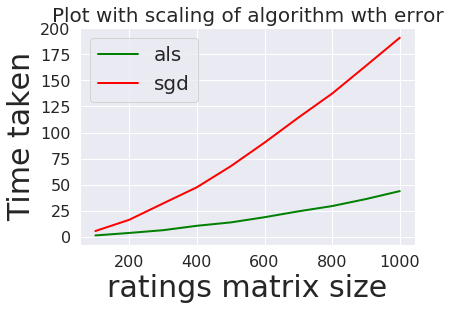

In [146]:
#plot the scaling of algorithm with the scaling of data
plt.plot(rating_subsets, time_als, 
         label='als', linewidth=2,color="green")
plt.plot(rating_subsets, time_sgd, 
         label='sgd', linewidth=2,color="red")


plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel('ratings matrix size', fontsize=30)
plt.ylabel('Time taken', fontsize=30)
plt.legend(loc='best', fontsize=20)
plt.title("Plot with scaling of algorithm wth error",fontsize=20)

We can see that the ALS algorithm scales much better than the SGD algorithm with matrix factorization. 

## Scaling of accuracy with data

In [106]:
data_sizes = [0,1,2,5] #run it for 100,200,300 and 600

In [107]:
best_params_als_scale_arr = []
best_params_sgd_scale_arr = []

In [108]:
for i in data_sizes:
    
    rating = ratings[i]
    train,cv,test = train_cv_test_split(rating,60)
    #tune ALS for different sizes
    print("running for {}".format(i))
    latent_factors = [ 20, 40, 80]
    regularizations = [0.1, 1., 10.]
    regularizations.sort()
    iter_array = np.linspace(0,200,21)

    best_params_als_scale = {}
    best_params_als_scale['latent_vectors'] = latent_factors[0]
    best_params_als_scale['reg'] = regularizations[0]
    best_params_als_scale['n_iter'] = 0
    best_params_als_scale['train_mse'] = np.inf
    best_params_als_scale['cv_mse'] = np.inf
    for fact in latent_factors:
        print('Factors: {}'.format(fact))
        for reg in regularizations:
            print('Regularization: {}'.format(reg))
            MF_ALS = MatrixFactorization(train, latent_vectors=fact, 
                                user_reg=reg, item_reg=reg,learning='als')
            MF_ALS.calc_learning_curve(iter_array, cv)
            min_idx = np.argmin(MF_ALS.test_mse)
            if MF_ALS.test_mse[min_idx] < best_params_als_scale['cv_mse'] and iter_array[min_idx] > 0:
                best_params_als_scale['latent_vectors'] = fact
                best_params_als_scale['reg'] = reg
                best_params_als_scale['n_iter'] = iter_array[min_idx]
                best_params_als_scale['train_mse'] = MF_ALS.train_mse[min_idx]
                best_params_als_scale['cv_mse'] = MF_ALS.test_mse[min_idx]
                best_params_als_scale['model'] = MF_ALS
                print('New optimal hyperparameters')
                print(pd.Series(best_params_als_scale))
                
    best_params_als_scale_arr.append(best_params_als_scale)
    
    #tune SGD for different sizes
    iter_array = np.linspace(0,200,21)
    latent_factors = [ 20, 40, 80]
    regularizations = [0.1, 1., 10.]
    regularizations.sort()

    best_params_sgd_scale = {}
    best_params_sgd_scale['latent_vectors'] = latent_factors[0]
    best_params_sgd_scale['reg'] = regularizations[0]
    best_params_sgd_scale['n_iter'] = 0
    best_params_sgd_scale['train_mse'] = np.inf
    best_params_sgd_scale['cv_mse'] = np.inf

    for fact in latent_factors:
        print('Factors: {}'.format(fact))
        for reg in regularizations:
            print('Regularization: {}'.format(reg))
            MF_SGD = MatrixFactorization(train, latent_vectors=fact, learning='sgd',
                                user_reg=reg, item_reg=reg)
            MF_SGD.calc_learning_curve(iter_array, cv, learning_rate=0.001)
            min_idx = np.argmin(MF_SGD.test_mse)
            if MF_SGD.test_mse[min_idx] < best_params_sgd_scale['cv_mse']:
                best_params_sgd_scale['latent_vectors'] = fact
                best_params_sgd_scale['reg'] = reg
                best_params_sgd_scale['n_iter'] = iter_array[min_idx]
                best_params_sgd_scale['train_mse'] = MF_SGD.train_mse[min_idx]
                best_params_sgd_scale['cv_mse'] = MF_SGD.test_mse[min_idx]
                best_params_sgd_scale['model'] = MF_SGD
                print('New optimal hyperparameters')
                print(pd.Series(best_params_sgd_scale))
    best_params_sgd_scale_arr.append(best_params_sgd_scale)

running for 0
Factors: 20
Regularization: 0.1
Iteration: 0.0
Train data  mse: 10.502265322938172
Test data mse: 10.644140018849756
Iteration: 10.0
Train data  mse: 5.24513768336431
Test data mse: 38.95881717004793
Iteration: 20.0
Train data  mse: 5.19393869793617
Test data mse: 39.059309725397874
Iteration: 30.0
Train data  mse: 5.169256030576039
Test data mse: 39.016555804573564
Iteration: 40.0
Train data  mse: 5.159134499784198
Test data mse: 38.9923340388415
Iteration: 50.0
Train data  mse: 5.153562061285843
Test data mse: 38.98708625244246
Iteration: 60.0
Train data  mse: 5.150231558829604
Test data mse: 38.98775560923253
Iteration: 70.0
Train data  mse: 5.148221270557326
Test data mse: 38.98931457748817
Iteration: 80.0
Train data  mse: 5.147007074082603
Test data mse: 38.99049395542627
Iteration: 90.0
Train data  mse: 5.14627275774519
Test data mse: 38.99117149948636
Iteration: 100.0
Train data  mse: 5.145828107443708
Test data mse: 38.9914793295038
Iteration: 110.0
Train data  ms

Train data  mse: 1.0318455861756757
Test data mse: 42.47154733180196
Iteration: 140.0
Train data  mse: 1.0318506109498202
Test data mse: 42.47166777335431
Iteration: 150.0
Train data  mse: 1.0318538936507204
Test data mse: 42.47174505835531
Iteration: 160.0
Train data  mse: 1.0318560345102132
Test data mse: 42.47179482963124
Iteration: 170.0
Train data  mse: 1.0318574291639462
Test data mse: 42.47182696894398
Iteration: 180.0
Train data  mse: 1.0318583370927157
Test data mse: 42.47184776440165
Iteration: 190.0
Train data  mse: 1.0318589279269497
Test data mse: 42.471861239973485
Iteration: 200.0
Train data  mse: 1.0318593123289201
Test data mse: 42.47186998180741
Regularization: 10.0
Iteration: 0.0
Train data  mse: 28.68857231125152
Test data mse: 28.472308199440455
Iteration: 10.0
Train data  mse: 5.5748673322836835
Test data mse: 38.713072527300525
Iteration: 20.0
Train data  mse: 5.5602257839477724
Test data mse: 38.75014486196398
Iteration: 30.0
Train data  mse: 5.559691800838926
T

Train data  mse: 5.355299028945321
Test data mse: 38.84055229935739
Iteration: 140.0
Train data  mse: 5.3553018345919785
Test data mse: 38.84054911179768
Iteration: 150.0
Train data  mse: 5.355303769685503
Test data mse: 38.84054691331072
Iteration: 160.0
Train data  mse: 5.355305106028967
Test data mse: 38.84054539508023
Iteration: 170.0
Train data  mse: 5.355306029688638
Test data mse: 38.8405443457069
Iteration: 180.0
Train data  mse: 5.355306668491592
Test data mse: 38.84054361996221
Iteration: 190.0
Train data  mse: 5.355307110471342
Test data mse: 38.8405431178294
Iteration: 200.0
Train data  mse: 5.3553074163595396
Test data mse: 38.840542770310506
New optimal hyperparameters
latent_vectors                                                   80
reg                                                              10
n_iter                                                          200
train_mse                                                   5.35531
cv_mse                              

Train data  mse: 0.5412963487698815
Test data mse: 5.437692859439453
Iteration: 160.0
Train data  mse: 0.4754843979728694
Test data mse: 5.456602267713531
Iteration: 170.0
Train data  mse: 0.4200445484823661
Test data mse: 5.472943116092235
Iteration: 180.0
Train data  mse: 0.37340347602568985
Test data mse: 5.487410357431236
Iteration: 190.0
Train data  mse: 0.3341449834587931
Test data mse: 5.500889285361196
Iteration: 200.0
Train data  mse: 0.3010073165496482
Test data mse: 5.511797815032682
Regularization: 1.0
Iteration: 0.0
Train data  mse: 29.91486922117215
Test data mse: 29.802233330201627
Iteration: 10.0
Train data  mse: 4.939793962799921
Test data mse: 6.844641674549542
Iteration: 20.0
Train data  mse: 4.341913851497617
Test data mse: 6.185740063933281
Iteration: 30.0
Train data  mse: 4.171611572464754
Test data mse: 6.001989386125606
Iteration: 40.0
Train data  mse: 4.092921311439243
Test data mse: 5.907394319662892
Iteration: 50.0
Train data  mse: 4.057686981343929
Test data

Train data  mse: 43.203127848363316
Test data mse: 43.36063081824548
Iteration: 70.0
Train data  mse: 43.59996954609033
Test data mse: 43.73724202668861
Iteration: 80.0
Train data  mse: 43.8336537298159
Test data mse: 43.95895212382139
Iteration: 90.0
Train data  mse: 43.97456286693863
Test data mse: 44.09217629010294
Iteration: 100.0
Train data  mse: 44.06218698051129
Test data mse: 44.17427294308716
Iteration: 110.0
Train data  mse: 44.11773511576293
Test data mse: 44.225613614774694
Iteration: 120.0
Train data  mse: 44.1539365149103
Test data mse: 44.25874588446001
Iteration: 130.0
Train data  mse: 44.178342916359426
Test data mse: 44.28028388324551
Iteration: 140.0
Train data  mse: 44.19523503853459
Test data mse: 44.29466286761986
Iteration: 150.0
Train data  mse: 44.207153187684376
Test data mse: 44.304522688334586
Iteration: 160.0
Train data  mse: 44.215784784974666
Test data mse: 44.31126895296276
Iteration: 170.0
Train data  mse: 44.222194082516324
Test data mse: 44.3160892770

Train data  mse: 4.346135543872244
Test data mse: 39.58993048425742
Iteration: 180.0
Train data  mse: 4.346009674512238
Test data mse: 39.58988002464432
Iteration: 190.0
Train data  mse: 4.345900376060635
Test data mse: 39.589831573873184
Iteration: 200.0
Train data  mse: 4.3458049435459145
Test data mse: 39.58978564548675
Regularization: 1.0
Iteration: 0.0
Train data  mse: 28.50172012855051
Test data mse: 27.764941345030348
Iteration: 10.0
Train data  mse: 4.564717098888278
Test data mse: 39.446947212341406
Iteration: 20.0
Train data  mse: 4.531882556766614
Test data mse: 39.470355284299316
Iteration: 30.0
Train data  mse: 4.524419158262488
Test data mse: 39.447606001834195
Iteration: 40.0
Train data  mse: 4.522051332489425
Test data mse: 39.43244772910597
Iteration: 50.0
Train data  mse: 4.521106857716352
Test data mse: 39.4229923832481
Iteration: 60.0
Train data  mse: 4.520636837458252
Test data mse: 39.416911346229284
Iteration: 70.0
Train data  mse: 4.520352478893954
Test data mse

Train data  mse: 3.7377318565945754
Test data mse: 39.835066389320346
Iteration: 20.0
Train data  mse: 3.7330927028752416
Test data mse: 39.85077438647175
Iteration: 30.0
Train data  mse: 3.7315691173681813
Test data mse: 39.85439699235144
Iteration: 40.0
Train data  mse: 3.731210445637133
Test data mse: 39.85539483726349
Iteration: 50.0
Train data  mse: 3.731094911384718
Test data mse: 39.85527659626893
Iteration: 60.0
Train data  mse: 3.7310238507030147
Test data mse: 39.85473952459451
Iteration: 70.0
Train data  mse: 3.7309657859332144
Test data mse: 39.85406566814616
Iteration: 80.0
Train data  mse: 3.7309165765648498
Test data mse: 39.853366364840625
Iteration: 90.0
Train data  mse: 3.7308760086936914
Test data mse: 39.852684552612885
Iteration: 100.0
Train data  mse: 3.7308441313021996
Test data mse: 39.85203594318041
Iteration: 110.0
Train data  mse: 3.730820726489878
Test data mse: 39.85142577353055
Iteration: 120.0
Train data  mse: 3.7308052811772336
Test data mse: 39.85085546

Train data  mse: 3.6979722148831327
Test data mse: 5.796067771216698
Iteration: 30.0
Train data  mse: 3.1948748792941677
Test data mse: 5.6884150619060625
Iteration: 40.0
Train data  mse: 2.8011819408356353
Test data mse: 5.653982344324457
Iteration: 50.0
Train data  mse: 2.452534935952408
Test data mse: 5.646573646031517
Iteration: 60.0
Train data  mse: 2.1315427580252786
Test data mse: 5.647989435646507
Iteration: 70.0
Train data  mse: 1.837265208362298
Test data mse: 5.655940409221425
Iteration: 80.0
Train data  mse: 1.5732777169054233
Test data mse: 5.6671401861779875
Iteration: 90.0
Train data  mse: 1.3411134092825552
Test data mse: 5.680494475795216
Iteration: 100.0
Train data  mse: 1.1431442202312165
Test data mse: 5.693479275078683
Iteration: 110.0
Train data  mse: 0.9762450198635529
Test data mse: 5.708046641893299
Iteration: 120.0
Train data  mse: 0.8381731504984961
Test data mse: 5.720198288152795
Iteration: 130.0
Train data  mse: 0.7246569079829996
Test data mse: 5.73175564

Train data  mse: 4.565289477083966
Test data mse: 6.24845864847728
Iteration: 150.0
Train data  mse: 4.58199116215109
Test data mse: 6.237049969525989
Iteration: 160.0
Train data  mse: 4.598452013577328
Test data mse: 6.227469888816632
Iteration: 170.0
Train data  mse: 4.608447984929354
Test data mse: 6.218997356786999
Iteration: 180.0
Train data  mse: 4.622756702001303
Test data mse: 6.209218304979827
Iteration: 190.0
Train data  mse: 4.6294533730932255
Test data mse: 6.198901522989091
Iteration: 200.0
Train data  mse: 4.636369912399324
Test data mse: 6.186904886072167
Regularization: 10.0
Iteration: 0.0
Train data  mse: 208.88388431254023
Test data mse: 209.57900638517617
Iteration: 10.0
Train data  mse: 30.811298718491837
Test data mse: 31.061512782112594
Iteration: 20.0
Train data  mse: 39.94134404665205
Test data mse: 39.88826082797373
Iteration: 30.0
Train data  mse: 43.06710266469617
Test data mse: 42.890182509320596
Iteration: 40.0
Train data  mse: 44.30746525979507
Test data m

Train data  mse: 7.449719314747288
Test data mse: 37.43487726518642
Iteration: 50.0
Train data  mse: 7.446996523773162
Test data mse: 37.439067343781836
Iteration: 60.0
Train data  mse: 7.444918717508724
Test data mse: 37.437990943327584
Iteration: 70.0
Train data  mse: 7.443240412655189
Test data mse: 37.435461780330435
Iteration: 80.0
Train data  mse: 7.441870623481485
Test data mse: 37.43299763334802
Iteration: 90.0
Train data  mse: 7.440748310949984
Test data mse: 37.43101791778606
Iteration: 100.0
Train data  mse: 7.4398233689551105
Test data mse: 37.4295456811021
Iteration: 110.0
Train data  mse: 7.43905460227178
Test data mse: 37.42849080408133
Iteration: 120.0
Train data  mse: 7.438409109897221
Test data mse: 37.4277492835855
Iteration: 130.0
Train data  mse: 7.437861201924902
Test data mse: 37.42723283729546
Iteration: 140.0
Train data  mse: 7.437391074653805
Test data mse: 37.42687407304523
Iteration: 150.0
Train data  mse: 7.436983538575531
Test data mse: 37.426624034398024


Train data  mse: 2.3630805891720277
Test data mse: 42.2170284776726
Iteration: 120.0
Train data  mse: 2.3631590002474216
Test data mse: 42.21697371555233
Iteration: 130.0
Train data  mse: 2.3632259472973978
Test data mse: 42.217018255060175
Iteration: 140.0
Train data  mse: 2.3632789412326303
Test data mse: 42.217091534558755
Iteration: 150.0
Train data  mse: 2.3633190881864454
Test data mse: 42.217163261285954
Iteration: 160.0
Train data  mse: 2.363348670764949
Test data mse: 42.217222713827084
Iteration: 170.0
Train data  mse: 2.363370065601882
Test data mse: 42.21726793427817
Iteration: 180.0
Train data  mse: 2.3633853338689734
Test data mse: 42.21730043377379
Iteration: 190.0
Train data  mse: 2.3633961201125206
Test data mse: 42.21732274928089
Iteration: 200.0
Train data  mse: 2.363403677415652
Test data mse: 42.217337406201366
New optimal hyperparameters
latent_vectors                                                   80
reg                                                         

Train data  mse: 45.759892926909686
Test data mse: 45.716120743133914
Iteration: 80.0
Train data  mse: 45.768504265407124
Test data mse: 45.724486246624004
Iteration: 90.0
Train data  mse: 45.77287363771427
Test data mse: 45.728568771745685
Iteration: 100.0
Train data  mse: 45.775350636871245
Test data mse: 45.730690799988274
Iteration: 110.0
Train data  mse: 45.7768750377089
Test data mse: 45.73186612944084
Iteration: 120.0
Train data  mse: 45.77786987268569
Test data mse: 45.732556879448765
Iteration: 130.0
Train data  mse: 45.77857313444721
Test data mse: 45.732983610333484
Iteration: 140.0
Train data  mse: 45.779078465046126
Test data mse: 45.733256921431284
Iteration: 150.0
Train data  mse: 45.779449260660854
Test data mse: 45.733434986343276
Iteration: 160.0
Train data  mse: 45.779736033387806
Test data mse: 45.73355975447089
Iteration: 170.0
Train data  mse: 45.779959153863274
Test data mse: 45.73364874985923
Iteration: 180.0
Train data  mse: 45.78013242977279
Test data mse: 45.

Train data  mse: 0.22113340151702965
Test data mse: 6.019692146835248
Iteration: 200.0
Train data  mse: 0.2114890393425083
Test data mse: 5.994555663786168
Regularization: 1.0
Iteration: 0.0
Train data  mse: 211.41480392035433
Test data mse: 210.5699892935239
Iteration: 10.0
Train data  mse: 5.482460550473772
Test data mse: 7.577546251530815
Iteration: 20.0
Train data  mse: 4.743482705201819
Test data mse: 6.6090639056685205
Iteration: 30.0
Train data  mse: 4.6000754162332305
Test data mse: 6.279862397403232
Iteration: 40.0
Train data  mse: 4.6042867155630205
Test data mse: 6.1460873536274025
Iteration: 50.0
Train data  mse: 4.651836422633273
Test data mse: 6.089385841149226
Iteration: 60.0
Train data  mse: 4.703403184305946
Test data mse: 6.065340044452622
Iteration: 70.0
Train data  mse: 4.749576832738478
Test data mse: 6.048787956014624
Iteration: 80.0
Train data  mse: 4.790840525080805
Test data mse: 6.041411463025086
Iteration: 90.0
Train data  mse: 4.828165423805618
Test data mse

Train data  mse: 19.882548348162466
Test data mse: 31.21861129107679
Iteration: 100.0
Train data  mse: 19.883649178974107
Test data mse: 31.220445045256078
Iteration: 110.0
Train data  mse: 19.88446351793227
Test data mse: 31.22182169733314
Iteration: 120.0
Train data  mse: 19.885067440531135
Test data mse: 31.222852653465562
Iteration: 130.0
Train data  mse: 19.885516936665184
Test data mse: 31.223624957702906
Iteration: 140.0
Train data  mse: 19.88585275648201
Test data mse: 31.22420441354684
Iteration: 150.0
Train data  mse: 19.88610452204028
Test data mse: 31.224640060142313
Iteration: 160.0
Train data  mse: 19.886293840925454
Test data mse: 31.22496826442404
Iteration: 170.0
Train data  mse: 19.8864365599987
Test data mse: 31.22521599270238
Iteration: 180.0
Train data  mse: 19.88654436960752
Test data mse: 31.225403284549888
Iteration: 190.0
Train data  mse: 19.886625942007075
Test data mse: 31.225545078643712
Iteration: 200.0
Train data  mse: 19.886687742390688
Test data mse: 31.

Train data  mse: 6.845228876090025
Test data mse: 38.71126036978456
New optimal hyperparameters
latent_vectors                                                   80
reg                                                             0.1
n_iter                                                           10
train_mse                                                   6.89322
cv_mse                                                      38.6407
model             <__main__.MatrixFactorization object at 0x7f00...
dtype: object
Regularization: 1.0
Iteration: 0.0
Train data  mse: 206.34659523622855
Test data mse: 203.109569998501
Iteration: 10.0
Train data  mse: 7.1081535179440705
Test data mse: 38.48120708350608
Iteration: 20.0
Train data  mse: 7.037147176452237
Test data mse: 38.57774155580658
Iteration: 30.0
Train data  mse: 7.0116835419347705
Test data mse: 38.612789409293946
Iteration: 40.0
Train data  mse: 6.998429499434745
Test data mse: 38.61716783882466
Iteration: 50.0
Train data  mse: 6.98966

Train data  mse: 5.272018426417905
Test data mse: 6.2066295411339
Iteration: 120.0
Train data  mse: 5.2725770807316215
Test data mse: 6.201814429940984
Iteration: 130.0
Train data  mse: 5.280388197064027
Test data mse: 6.2068069579347735
Iteration: 140.0
Train data  mse: 5.281578405720883
Test data mse: 6.209025854761836
Iteration: 150.0
Train data  mse: 5.279904242598819
Test data mse: 6.203187064285548
Iteration: 160.0
Train data  mse: 5.282613075828958
Test data mse: 6.202221548293133
Iteration: 170.0
Train data  mse: 5.281294336966549
Test data mse: 6.200485607414026
Iteration: 180.0
Train data  mse: 5.28266085303737
Test data mse: 6.202911900185668
Iteration: 190.0
Train data  mse: 5.282208387608529
Test data mse: 6.2015553323592405
Iteration: 200.0
Train data  mse: 5.284398085327934
Test data mse: 6.198943151318344
Regularization: 10.0
Iteration: 0.0
Train data  mse: 11.431049194333985
Test data mse: 11.99140062363388
Iteration: 10.0
Train data  mse: 41.64965279164686
Test data m

Train data  mse: 4.880705407437133
Test data mse: 7.57140112358365
Iteration: 20.0
Train data  mse: 3.3418836552793323
Test data mse: 6.546231221850778
Iteration: 30.0
Train data  mse: 2.5564513891267664
Test data mse: 6.211364393712251
Iteration: 40.0
Train data  mse: 2.009892725411677
Test data mse: 6.060617068786035
Iteration: 50.0
Train data  mse: 1.599105786323909
Test data mse: 5.989456667214697
Iteration: 60.0
Train data  mse: 1.2857424744365606
Test data mse: 5.946643233463817
Iteration: 70.0
Train data  mse: 1.0480268752192925
Test data mse: 5.919286901522094
Iteration: 80.0
Train data  mse: 0.8687683150178954
Test data mse: 5.900233452719114
Iteration: 90.0
Train data  mse: 0.7334735212594135
Test data mse: 5.880237704767608
Iteration: 100.0
Train data  mse: 0.6310281339133942
Test data mse: 5.861378482904004
Iteration: 110.0
Train data  mse: 0.5528399358233674
Test data mse: 5.842030739012779
Iteration: 120.0
Train data  mse: 0.4922405750355595
Test data mse: 5.8198375288027

## Plotting the error with scalling data

In [109]:
colors = ["red","green","blue","yellow"] #for 100,200,300,600

In [119]:
data_size = [100,200,300,600]

Text(0.5, 1.0, 'Plot with mean square error')

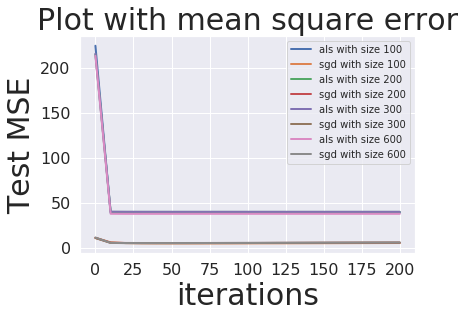

In [120]:
for i in range(len(data_sizes)):
    model_als = best_params_als_scale_arr[i]["model"]
    plt.plot(iter_array, model_als.test_mse, \
             label="als with size "+str(data_size[i]), linewidth=2)

    model_sgd = best_params_sgd_scale_arr[i]["model"]
    plt.plot(iter_array, model_sgd.test_mse, \
             label="sgd with size "+str(data_size[i]), linewidth=2)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel('iterations', fontsize=30)
plt.ylabel('Test MSE', fontsize=30)
plt.legend(loc='best', fontsize=10)
plt.title("Plot with mean square error",fontsize=30)

Text(0.5, 1.0, 'Plot with mean square error')

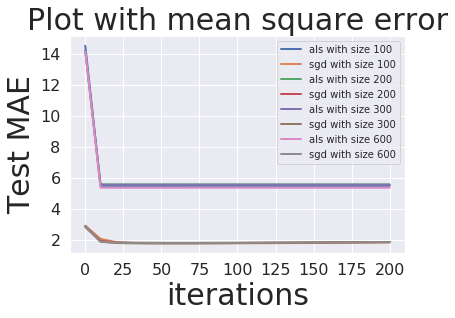

In [121]:
for i in range(len(data_sizes)):
    model_als = best_params_als_scale_arr[i]["model"]
    plt.plot(iter_array, model_als.test_mae, \
             label="als with size "+str(data_size[i]), linewidth=2)

    model_sgd = best_params_sgd_scale_arr[i]["model"]
    plt.plot(iter_array, model_sgd.test_mae, \
             label="sgd with size "+str(data_size[i]), linewidth=2)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel('iterations', fontsize=30)
plt.ylabel('Test MAE', fontsize=30)
plt.legend(loc='best', fontsize=10)
plt.title("Plot with mean square error",fontsize=30)

In [113]:
best_params_sgd_scale_arr

[{'latent_vectors': 20,
  'reg': 0.1,
  'n_iter': 60.0,
  'train_mse': 2.714462094640763,
  'cv_mse': 4.85333485104555,
  'model': <__main__.MatrixFactorization at 0x7f00b8c7bbe0>},
 {'latent_vectors': 20,
  'reg': 0.1,
  'n_iter': 40.0,
  'train_mse': 3.4752651599566255,
  'cv_mse': 5.309900453326315,
  'model': <__main__.MatrixFactorization at 0x7f00b8c64c18>},
 {'latent_vectors': 20,
  'reg': 0.1,
  'n_iter': 40.0,
  'train_mse': 3.4549888191591753,
  'cv_mse': 5.088200410039063,
  'model': <__main__.MatrixFactorization at 0x7f00b8ce4978>},
 {'latent_vectors': 20,
  'reg': 0.1,
  'n_iter': 40.0,
  'train_mse': 3.5492985663961845,
  'cv_mse': 5.253507753430824,
  'model': <__main__.MatrixFactorization at 0x7f00b8ce45c0>}]

In [112]:
best_params_als_scale_arr

[{'latent_vectors': 80,
  'reg': 10.0,
  'n_iter': 200.0,
  'train_mse': 5.3553074163595396,
  'cv_mse': 38.840542770310506,
  'model': <__main__.MatrixFactorization at 0x7f00b8c7b2e8>},
 {'latent_vectors': 80,
  'reg': 10.0,
  'n_iter': 10.0,
  'train_mse': 3.7377318565945754,
  'cv_mse': 39.835066389320346,
  'model': <__main__.MatrixFactorization at 0x7f00b8c6cd68>},
 {'latent_vectors': 80,
  'reg': 10.0,
  'n_iter': 200.0,
  'train_mse': 4.586976747245979,
  'cv_mse': 39.965165384013815,
  'model': <__main__.MatrixFactorization at 0x7f00b8ce4b00>},
 {'latent_vectors': 80,
  'reg': 10.0,
  'n_iter': 20.0,
  'train_mse': 8.590625318554835,
  'cv_mse': 37.704189374792854,
  'model': <__main__.MatrixFactorization at 0x7f00b8c7b588>}]

In [ ]:
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel('iterations', fontsize=30)
plt.ylabel('MSE', fontsize=30)
plt.legend(loc='best', fontsize=20)
plt.title("Plot with mean square error",fontsize=30)

In [48]:
df_hyperparams = pd.DataFrame(columns=["fac1","fac2","fac3","fac4","error1"])

In [52]:
df_hyperparams.append({"fac1":2,"a":3},ignore_index=True)

,fac1,fac2,fac3,fac4,error1,a
0,2.0,NaN,NaN,NaN,NaN,3.0


In [42]:
?df_hyperparams.append